# Evaluate hawkears classifications on the train split of the dataset. 
The database was split into test and training sets - this was done by ARU location. I ran the HawkEars model on all the recordings in the training split and saved the results in order to do model comparision. 

The hawkears output is in files corresponding to recording file. The input files are numbered and this number is used by HawkEars to name the output files, so we can match the HawkEars prediction files with the audio clips. 

In [21]:
# imports
import glob
from pathlib import Path
import pandas as pd

# for utils
from pathlib import Path
import sys
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import display_all, keep_cols, clean_confidence_cats
import src.utils as utils
import sklearn
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, average_precision_score, roc_auc_score, precision_recall_curve

import matplotlib.pyplot as plt
import torch

In [24]:
data_path = Path.cwd().parent.parent / 'data'
hawkears_output_path = Path(data_path / 'processed' / 'hawkears_predictions')
valid_df = pd.read_pickle(data_path / 'interim' / 'valid_set' / 'valid_df_verified.pkl')
valid_df = clean_confidence_cats(valid_df)
valid_df = valid_df[['target_presence']]

In [27]:
valid_df.index

MultiIndex([(   ../../data/raw/recordings/OSFL/recording-4478.mp3,  0.0,  3.0),
            (   ../../data/raw/recordings/OSFL/recording-4478.mp3,  1.5,  4.5),
            (   ../../data/raw/recordings/OSFL/recording-4478.mp3,  3.0,  6.0),
            (   ../../data/raw/recordings/OSFL/recording-4478.mp3,  4.5,  7.5),
            (   ../../data/raw/recordings/OSFL/recording-4478.mp3,  6.0,  9.0),
            (   ../../data/raw/recordings/OSFL/recording-4478.mp3,  7.5, 10.5),
            (   ../../data/raw/recordings/OSFL/recording-4478.mp3,  9.0, 12.0),
            (   ../../data/raw/recordings/OSFL/recording-4478.mp3, 10.5, 13.5),
            (   ../../data/raw/recordings/OSFL/recording-4478.mp3, 12.0, 15.0),
            (   ../../data/raw/recordings/OSFL/recording-4478.mp3, 13.5, 16.5),
            ...
            (../../data/raw/recordings/OSFL/recording-816752.flac, 24.0, 27.0),
            (../../data/raw/recordings/OSFL/recording-816752.flac, 25.5, 28.5),
            (../../data/

In [3]:
hawkears_output = glob.glob(str(hawkears_output_path / '*.txt'))
hawkears_output[0]

'/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/hawkears_predictions/555135_HawkEars.txt'

In [4]:
def get_df_from_3s_clips(hawkears_outputs, label):
    results = []
    # Read and parse the file contents
    for file_path in hawkears_outputs:
        with open(file_path, 'r') as f:
            file_content = f.read().strip().split('\n')
            file_id = file_path.split('/')[-1].split('-')[0]
            file_id = file_id.split('_')[0]
            for detection in file_content:
                if detection:
                    line = [file_id] + detection.split('\t')
                else:
                    line=[file_id]
                results.append(line)     

    # Convert the results to a pandas DataFrame
    df = pd.DataFrame(results, columns=['file_id', 'start_time', 'end_time', 'species;confidence'])
    df.file_id = df.file_id.astype(int)
    df.sort_values(by=['file_id'], inplace=True)
    df[['species', 'confidence']] = df['species;confidence'].str.split(';', expand=True)
    df.drop(columns=['species;confidence'], inplace=True)
    df.confidence = df.confidence.astype(float)
    return df.reset_index(drop=True)

In [5]:
df = get_df_from_3s_clips(hawkears_output, 1)


In [6]:
df.to_pickle(data_path / 'processed' / 'hawkears_predictions.pkl')


In [28]:
df.head()

,file_id,start_time,end_time,species,confidence,label
0,4429,175.50,178.50,YTWA,0.01,1
1,4429,12.00,15.00,PISI,0.01,1
2,4429,10.50,13.50,PISI,0.01,1
3,4429,9.00,12.00,PISI,0.01,1
4,4429,7.50,10.50,PISI,0.01,1


With the threshold set to 0 in HawkEars, the model should output a confidence for each of the 306 birds, for each of the 3s clips. We can choose a threshold then try out the accuracy metric in sklearn.

In [121]:
df.species.nunique()
df.file_id.nunique()

1579

# This section attempts to filter the predictions down to the exact files in the validation set

In [40]:
osfls = df.loc[df['species'] == "OSFL"].copy()
len(osfls)

179283

In [104]:
# Get the numeric part of the validation set files
valid_df_file_ids = valid_df.index.get_level_values('file')
valid_df_file_ids = [str(x) for x in valid_df_file_ids]
valid_df_file_ids = [x.split('.')[-2].split('-')[-1] for x in valid_df_file_ids]
valid_df_file_ids = [float(x) for x in valid_df_file_ids]

In [119]:
valid_df_osfls = osfls.loc[osfls['file_id'].isin(valid_df_file_ids)]

In [117]:
osfls = valid_df_osfls
len(valid_df), len(osfls)

(10334, 27703)

#### Predictions are actually already made. We're just filtering them since the threshold is 0.

In [110]:
def make_predictions(df, threshold):
    df["prediction"] = df.apply(lambda x: 1 if x["confidence"] > threshold else 0, axis=1)
    return df

osfls = make_predictions(osfls, 0.7)
osfls.head()

/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_45121/1300551645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["prediction"] = df.apply(lambda x: 1 if x["confidence"] > threshold else 0, axis=1)


,file_id,start_time,end_time,species,confidence,label,prediction
154123,4504,145.50,148.50,OSFL,0.01,1,0
154124,4504,144.00,147.00,OSFL,0.01,1,0
154125,4504,142.50,145.50,OSFL,0.01,1,0
154126,4504,141.00,144.00,OSFL,0.01,1,0
154127,4504,139.50,142.50,OSFL,0.02,1,0


# Calculate the accuracy of the model with various thresholds

The label column isn't defined and needs filling in by loading these values out of the validation set.

In [111]:
accuracy_score(osfls.label, osfls.prediction)

0.04331660830956936

/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_45121/1300551645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["prediction"] = df.apply(lambda x: 1 if x["confidence"] > threshold else 0, axis=1)
/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_45121/1300551645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["prediction"] = df.apply(lambda x: 1 if x["confidence"] > threshold else 0, axis=1)
/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_45121/1300551645.py:2: 

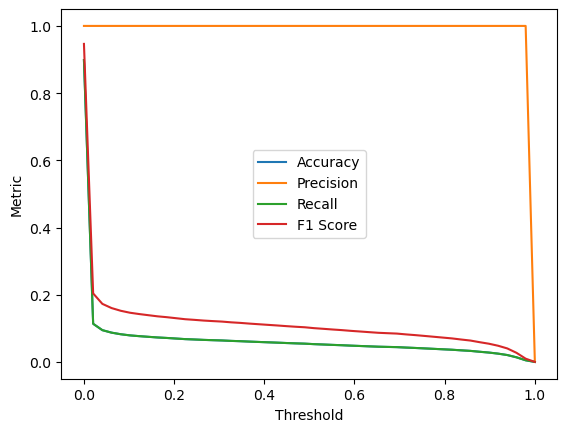

In [112]:
plot_data = []
for threshold in torch.linspace(0, 1, 50):
    osfls = make_predictions(osfls, threshold)
    plot_data.append(
        [
            threshold,
            accuracy_score(osfls.label, osfls.prediction),
            precision_score(osfls.label, osfls.prediction),
            recall_score(osfls.label, osfls.prediction),
            f1_score(osfls.label, osfls.prediction),
        ]
    )


thresholds, accuracies, precisions, recalls, f1s = zip(*plot_data)
plt.plot(thresholds, accuracies)
plt.plot(thresholds, precisions)
plt.plot(thresholds, recalls)
plt.plot(thresholds, f1s)
ax, fig = plt.gca(), plt.gcf()
ax.set_xlabel("Threshold")
ax.set_ylabel("Metric")
ax.legend(["Accuracy", "Precision", "Recall", "F1 Score"])
plt.show()

A reminder about the meaning of these metrics:
- Precision: the proportion of positive identifications that were actually correct
- Recall: the proportion of actual positives that were correctly identified
- Accuracy: the proportion of true results (both true positives and true negatives) among the total number of cases examined

Calculate the average precision 

In [15]:
average_precision_score(osfls.label, osfls.confidence)

0.8015973513425184

In [16]:
len(osfls.loc[osfls['label']==0])/len(osfls)

0.5

In [17]:
osfls = make_predictions(osfls, 0.5)
targets = osfls.loc[osfls.label==1]
len(targets)

388

In [18]:
hits = len(targets.loc[targets.prediction==1])
hits / len(targets)

0.3118556701030928

### Though the precision is close to 1, the model still only gets 30% of the calls present in the dataset. 

## Calculate the ROC and AUC   

In [19]:
roc = roc_auc_score(osfls.label, osfls.confidence)
roc

0.7965212828143267

## Calcualte the precision-recall curve

In [20]:
pr_curve = precision_recall_curve(osfls.label, osfls.confidence)

In [21]:
sklearn.metrics.auc(pr_curve[1], pr_curve[0])

0.8773320471238845

Text(0.5, 1.0, 'OSFL only PR Curve HawkEars, 50/50 class balance')

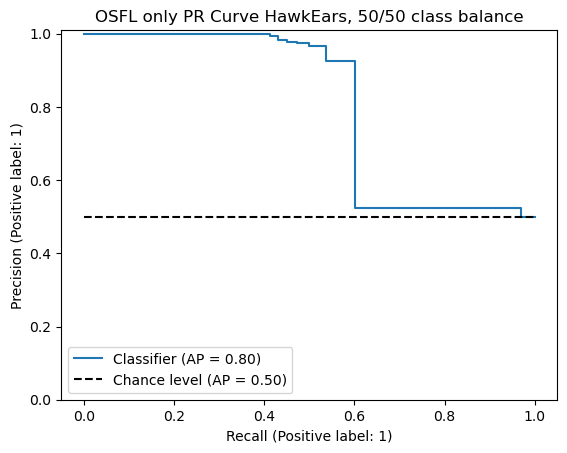

In [22]:
pr_curve_plot = sklearn.metrics.PrecisionRecallDisplay.from_predictions(osfls.label, osfls.confidence, plot_chance_level=True)
pr_curve_plot.ax_.set_ylim(0, 1.01)
pr_curve_plot.ax_.set_title("OSFL only PR Curve HawkEars, 50/50 class balance")

## Error checking: Is the test data actually labelled correctly?
Hawkears returned 30% of the positive samples in this test set, whereas the author of Hawkears measured 70%. This could be explained by either some of my test data being labelled incorrectly, or some of the data at the other end comprising of more focal audio clips. 

In [24]:
audio_path = data_path/ "processed" / "audio_clips" / "valid" / "absent"
audio_clips = glob.glob(str(audio_path) + "/*")
Path(audio_clips[0]).name

'01192-4.5-7.5-recording-280076.mp3'

In [25]:
def audio_clip_to_original_df(audio_clip):
    _, start_time, end_time, _,  recording_id = Path(audio_clip).stem.split("-")
    recording_id = int(recording_id)
    file_extension = Path(audio_clip).suffix
    return recording_id, start_time, end_time, file_extension

In [26]:
# Collect the relevant id, start and end times into pandas dataframe
present_df = pd.DataFrame([audio_clip_to_original_df(audio_clip) for audio_clip in audio_clips], columns=["recording_id", "start_time", "end_time", "file_extension"])
absent_df = pd.DataFrame([audio_clip_to_original_df(audio_clip) for audio_clip in audio_clips], columns=["recording_id", "start_time", "end_time", "file_extension"])

In [27]:
original_df = pd.read_pickle(data_path / "processed" / "train_set" / "train_set.pkl")

# filter by keep_cols
original_df = original_df[keep_cols]
# filter by recording id
intersect_df = original_df.loc[original_df.recording_id.isin(present_df.recording_id)]
# drop all except the olive sided flycatcher recs
intersect_df = intersect_df.loc[intersect_df.species_code == "OSFL"]
intersect_df.sample(5)

,organization,project,project_id,location_id,recording_id,recording_date_time,species_code,species_common_name,detection_time,task_duration,tag_duration,tag_id,clip_url,recording_url,task_method,latitude,longitude,file_type,media_url,individual_order
388044,BU,Lebeuf-Taylor - 2023 RETN,2044,480654,815817,2023-06-22 06:33:00,OSFL,Olive-sided Flycatcher,42.90,60.0,0.90,3501564,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,NaN,51.556830,-115.020690,flac,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0
184371,CWS-ONT,CWS-Ontario Birds of James Bay Lowlands 2021,885,194717,293422,2021-06-17 04:16:00,OSFL,Olive-sided Flycatcher,72.64,180.0,1.01,2538247,https://wildtrax-aru-ca.s3.ca-central-1.amazon...,https://wildtrax-aru-ca.s3.ca-central-1.amazon...,1SPT,52.088900,-84.357200,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,2.0
141254,CWS-ONT,CWS-Ontario Atlas Northern River Trips 2022,1475,474158,613714,2022-06-23 04:36:00,OSFL,Olive-sided Flycatcher,19.93,60.0,1.54,3275070,https://wildtrax-aru-ca.s3.ca-central-1.amazon...,https://wildtrax-aru-ca.s3.ca-central-1.amazon...,1SPT,51.556309,-85.933016,flac,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0
380886,BU,Lebeuf-Taylor - 2022 RETN,1115,308711,413782,2022-06-04 06:45:00,OSFL,Olive-sided Flycatcher,54.84,60.0,1.21,2784121,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,NaN,54.900173,-118.708697,flac,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0
82660,BU,Boreal Wetland Community Monitoring,41,32647,48543,2018-06-22 04:35:00,OSFL,Olive-sided Flycatcher,122.65,180.0,1.19,117035,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,57.403310,-111.256486,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0


In [28]:

intersect_df.columns

Index(['organization', 'project', 'project_id', 'location_id', 'recording_id',
       'recording_date_time', 'species_code', 'species_common_name',
       'detection_time', 'task_duration', 'tag_duration', 'tag_id', 'clip_url',
       'recording_url', 'task_method', 'latitude', 'longitude', 'file_type',
       'media_url', 'individual_order'],
      dtype='object')

/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:82: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  canada = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")).query(
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:106: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  points.plot(


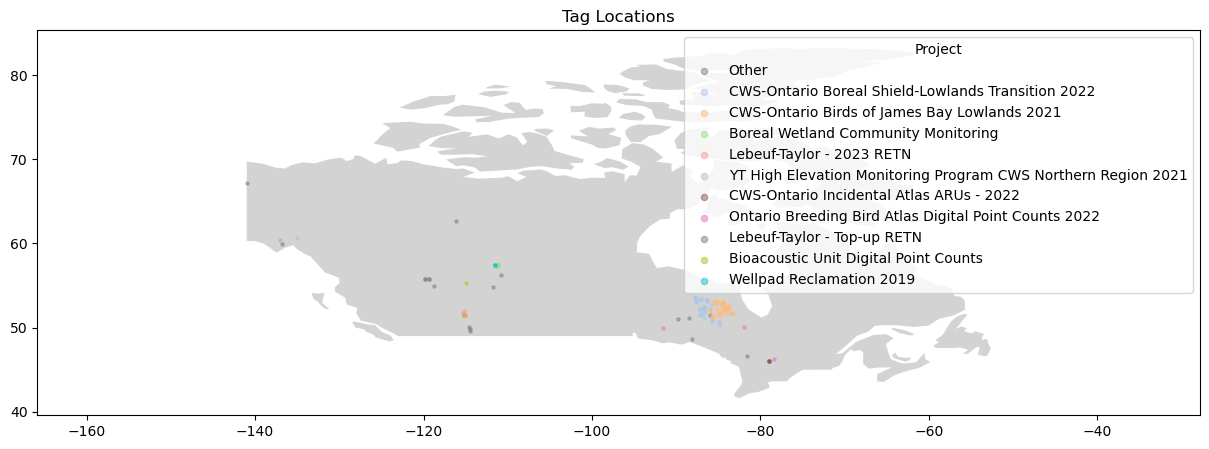

In [29]:
# show the locations of these recordings
utils.plot_locations(intersect_df, feature="project")

In [39]:
present_df['label']=1
absent_df['label']=0

In [42]:
pd.concat([present_df, absent_df], axis=0, ignore_index=True).to_csv("test_set.csv")

In [31]:
absent_df

,recording_id,start_time,end_time,file_extension
0,280076,4.5,7.5,.mp3
1,556097,0.0,3.0,.flac
2,330530,55.5,58.5,.flac
3,552592,87.0,90.0,.flac
4,291508,220.5,223.5,.mp3
...,...,...,...,...
383,144812,6.0,9.0,.mp3
384,555642,13.5,16.5,.flac
385,552947,16.5,19.5,.flac
386,291508,76.5,79.5,.mp3


After running this randomly sampled set of test data through HawkEars and measuring a lower recall than expected, I looked at each of the 388 samples in the validation-present set to see what kinds of audio might be producing false negatives. 

I was able to count olive sided flycatcher songs in 312 out of the 388 human labelled clips. Some of them were very hard to tell, so I could be off by +- 10% or so. 

The audio dataset did contain some very noisy clips - some which just looked and sounded like white noise. Some other clips looked like mis-identifications on behalf of the human labeler. 

It seems there's a line to tread between curating the test set to contain only the most clear and obvious examples of the target species, and curating the test set to contain a representative sample of the data. 

Ultimately though so long as the same test set is used to evaluate each model, then a statement can be made about the relative performance of each model. 